In [1]:
#load aiida environment and connect to database
from aiida import load_profile

profile = load_profile()
print('profile name : ',profile.name)
print('profile database host name : ',profile.database_hostname)
print('default user : ',profile.default_user)
import seaborn as sns

profile name :  default
profile database host name :  localhost
default user :  r.mozumder@fz-juelich.de


In [2]:
# load classes and functions
from aiida.orm import CifData, Code, Dict, load_node, StructureData 
from aiida.orm import (Group, load_group, load_node, load_code, groups,groups,
                      WorkChainNode)
from aiida.engine import submit, exceptions
from aiida.common.exceptions import NotExistent
from aiida_kkr.workflows import kkr_imp_sub_wc, kkr_imp_dos, kkr_imp_wc, kkr_startpot_wc, combine_imps_wc
import numpy as np
from aiida_kkr.calculations import KkrimpCalculation, VoronoiCalculation
import matplotlib.pyplot as plt
from aiida_kkr.tools.common_workfunctions import get_username
import matplotlib.gridspec as gridspec
from aiida_kkr.tools import plot_kkr


In [3]:
# This is the more stable and smart one
### To extract data from the two combine impurities as well as single imp to plot :
## In this step if 
def ExtractLastCalcData(group_pk, Average= True, **kargs):
    
    """
    param: group_pk : Only excepts the Identifier or label 
    param: kargs : key_pair_value1, key_pair_value2, to search for data from  the last_calc_output_param.
                   The keys are "key of keys"
                    e.i. last_calc_output_param[value1][value2].
    """
    import numpy as np
    from aiida.common.constants import elements as elmt
    import math

    sym_to_zimp = {elmt[zimp]['symbol']:zimp for zimp in elmt.keys()}
    
    combine_imps_group = load_group(group_pk)
    combine_nodes_list = list(combine_imps_group.nodes)
    plot_zimp_row_list = []  # list of imp along the y-axis
    plot_zimp_col_list = [0] # list of imp along the x-axis this extra '0' is indented for singel imp

    for node in combine_nodes_list[:]:
        ## Here to arrange the imps for once, intending for x-axis, plot_col_list, and for y-axis, plot_row_list 
        
        zimp1, zimp2 = sym_to_zimp[node.label.split(':')[0]], sym_to_zimp[node.label.split(':')[1]]
        ## Here only one imp will be consider for once
        if zimp1 not in plot_zimp_row_list:
            plot_zimp_row_list.append(zimp1)
        if zimp2 not in plot_zimp_col_list:
            plot_zimp_col_list.append(zimp2)

    plot_zimp_row_list.sort()
    plot_zimp_col_list.sort()
            
    plot_imp_row_list = [elmt[zimp]['symbol'] for zimp in plot_zimp_row_list]
    plot_imp_col_list = [elmt[zimp]['symbol'] for zimp in plot_zimp_col_list]

    print('len of plot_imp_row_list', len(plot_imp_row_list))
    print('len of plot_imp_col_list', len(plot_imp_col_list))

    # Extract all the total_spin_momentum from the combine_imps_wc as well as single impurity
    def extract_last_calc_data(combine_nodes_list, **kargs):
        node_list = combine_nodes_list
        extr_comb_dict = {}
        extr_single_dict = {}
        already_search_imp_list= []

        for nod in node_list[:]:
            single_imp_wc = nod.inputs.impurity1_output_node.get_incoming(node_class=kkr_imp_wc).first().node
            zimp= single_imp_wc.inputs.impurity_info.get_dict()['Zimp']
            if zimp not in already_search_imp_list:
                already_search_imp_list.append(zimp)

                out_dict = single_imp_wc.outputs.last_calc_output_parameters.get_dict()
                for val in kargs.values():
                    out_dict =  out_dict[val]
                single_imp_val = out_dict
           
                imp1_symbol= elmt[zimp]['symbol']
                extr_single_dict[imp1_symbol]= single_imp_val

            key= nod.label.split(':')[0] + nod.label.split(':')[1]
            
            out_dict = nod.outputs.last_calc_output_parameters.get_dict()
            for val in kargs.values():
                out_dict =  out_dict[val]
            val = out_dict

            extr_comb_dict[key]= val

        return extr_comb_dict, extr_single_dict

    # To fill the 2d plot data from the kkrimp_last_calc
    impcalc_data_array = np.zeros(shape= (len(plot_imp_row_list), len(plot_imp_col_list)), dtype= float)
    extr_comb_dict, extr_single_dict = extract_last_calc_data(combine_nodes_list, **kargs)
    row_index= 0
    col_index= 1 # Here the index '0' is skiped as it is fillled with empty string 'xx'
                 # and the coresponding column will be filles with the data extracted
                 # from the singel imp calc data

    for imp1 in plot_imp_row_list[:]:
        col_index = 1
        for imp2 in plot_imp_col_list[1:]:

            if col_index==1:
                ## Here the first column will be fullfiled with the single im_data
                impcalc_data_array[row_index, col_index-1] = extr_single_dict[imp1]
            search_key = plot_imp_row_list[row_index]  + plot_imp_col_list[col_index]
            if search_key in  extr_comb_dict.keys():
                impcalc_data_array[row_index, col_index] =  extr_comb_dict[search_key]
            else:
                impcalc_data_array[row_index, col_index] =  np.nan 

            col_index += 1
        row_index += 1

    plot_data_shape = np.shape(impcalc_data_array)
    if Average:
        CutCol= plot_imp_col_list[1:]
        ## Doing the transpose matrix
        ## In the single cut array first col will be removed from the array
        CutArr= impcalc_data_array[:, 1:]
        for imp1 in plot_imp_row_list:
            y_index= plot_imp_row_list.index(imp1)
            
            for imp2 in CutCol:
                x_index= CutCol.index(imp2)
                if math.isnan(CutArr[x_index,y_index]):
#                    print(f'imp1:imp2= {imp1}:{imp2}, index= {x_index, y_index}, exch_index= {y_index, x_index}')
                    exch_row_col_val= CutArr[y_index,x_index]
                    CutArr[x_index, y_index]= exch_row_col_val
                
        CutArrTrans= CutArr.T
        CutArr+= CutArrTrans
        impcalc_data_array[:,1:]= CutArr/2
        impcalc_data_array = impcalc_data_array
    
    print(plot_imp_col_list)
    print(plot_imp_row_list)
    
    return impcalc_data_array, plot_imp_col_list, plot_imp_row_list

## To extract the data from jij calcculation
def ExtractJijData(group_pk, jij_data_position:int=None, D_dev_J=None, atoms_info: bool= True, Average= True):
    from aiida_kkr.calculations import KkrCalculation
    import math

    """
    param: group_pk : Only excepts the ID
    
    jij_data_position: (0: dr_1, 1:dr_2, 2:dr_3)distance between atoms, 3:J, 4:D(abs value),
                        5:Dx, 6:Dy, 7:Dz  
    D_dev_J: True, to calculate the D J ratio
    atoms_info: To get the atom indices
    Average: To average the ndarray specialy for 
    param: kargs : key_1, key2, to search for data from  the last_calc_output_param 
    """
    import numpy as np
    from aiida.common.constants import elements as elmt
    sym_to_zimp = {elmt[zimp]['symbol']:zimp for zimp in elmt.keys()}
    
    combine_imps_group = load_group(group_pk)
    combine_nodes_list = list(combine_imps_group.nodes)
    plot_zimp_row_list = []  # This is the list considered as zimp along the y-axis
    plot_zimp_col_list = []  # This is the list considered as zimp along the x-axis

    for node in combine_nodes_list[:]:
        ## Here to arrange the imps for once, intending for x-axis, 
        ## plot_col_list, and y-axis, plot_row_list 
        
        zimp1, zimp2 = sym_to_zimp[node.label.split(':')[0]], sym_to_zimp[node.label.split(':')[1]]
        ## Here only one imp will be consider for once
        if zimp1 not in plot_zimp_row_list:
            plot_zimp_row_list.append(zimp1)
        if zimp2 not in plot_zimp_col_list:
            plot_zimp_col_list.append(zimp2)
    
    plot_zimp_row_list.sort()
    plot_zimp_col_list.sort()

    # This is the list considered as the label for yticks
    plot_imp_row_list = [elmt[zimp]['symbol'] for zimp in plot_zimp_row_list]
    # This is the list considered as the label for yticks
    plot_imp_col_list = [elmt[zimp]['symbol'] for zimp in plot_zimp_col_list]

    print('len of plot_imp_row_list', len(plot_imp_row_list))
    print('len of plot_imp_col_list', len(plot_imp_col_list))

    # Extract the JijData and JijInfo from the list of combined_imps_node_list
    def extract_jij(combine_nodes_list, jij_data_position:int=None, D_dev_J=None, atoms_info: bool= True):
        node_list = combine_nodes_list
        extr_comb_dict = {}
# del         extr_single_dict = {}
# del         already_search_imp_list= []
# TODO: delete the line with #del 

        Jij_data = None
        some_info_dict = {}
        for nod in node_list[:]:
            key= nod.label.split(':')[0] + nod.label.split(':')[1]
        
            if jij_data_position in [3,4]:
                Jij_data = nod.outputs.JijData.get_array('JijData')[0,:]
                Jij_info = nod.outputs.JijInfo.get_dict()['text'].split('\n')[3].split()
                extr_comb_dict[key]= Jij_data[jij_data_position]
            elif  D_dev_J==True:
                Jij_data = nod.outputs.JijData.get_array('JijData')[0,:]
                Jij_info = nod.outputs.JijInfo.get_dict()['text'].split('\n')[3].split()
                d_j = Jij_data[4]/Jij_data[3]
                extr_comb_dict[key] = d_j
            else:
                print('provide valid input in the funcion ExtractJijData.')
        try:
            kkr_calc= combine_nodes_list[0].outputs.remote_data_gf.get_incoming(node_class=KkrCalculation).all()[0].node
        except:
            kkr_calc= combine_nodes_list[0].inputs.gf_host_remote.get_incoming(node_class=KkrCalculation).all()[0].node
        kkr_output_dict= kkr_calc.outputs.output_parameters.get_dict()
        
# TODO: Add a if statement to take into account only jij_position or D_div_J

## This section regarding for two impurities 
        if atoms_info:
            dist = np.sqrt(np.sum([i**2 for i in Jij_data[0:3]]))
            imps_index = (int(Jij_info[0]), int(Jij_info[1]))
            some_info_dict = {'some_info':{ 'imp_indices' : imps_index ,
                                            'atom_distance' : dist,
                                            'alat' :kkr_output_dict['alat_internal'],
                                            'alat_unit': 'Bohr'
                                            }
                             }

        return extr_comb_dict, some_info_dict #, extr_single_dict

    # To fill the 2d plot data here
    jij_data_array = np.zeros(shape= (len(plot_imp_row_list), len(plot_imp_col_list)), dtype= float)
    extr_comb_dict, some_info_dict = extract_jij(combine_nodes_list, jij_data_position=jij_data_position, D_dev_J=D_dev_J, atoms_info=atoms_info)
    row_index= 0
    col_index= 0 # Here the index '0' is skiped as it is fillled with empty string 'xx'
                 # and the coresponding column will be filles with the data extracted
                 # from the singel imp calc data

    for imp1 in plot_imp_row_list[:]:
        col_index = 0
        for imp2 in plot_imp_col_list[:]:

            search_key = plot_imp_row_list[row_index]  + plot_imp_col_list[col_index]
            if search_key in  extr_comb_dict.keys():
                jij_data_array[row_index, col_index] =  extr_comb_dict[search_key]
            else:
                jij_data_array[row_index, col_index] =  np.nan 

            col_index += 1
        row_index += 1
## Average the map 
    if Average:
        
        for imp1 in plot_imp_row_list:
            y_index= plot_imp_row_list.index(imp1)
            for imp2 in plot_imp_col_list:
                x_index= plot_imp_col_list.index(imp2)
                if math.isnan(jij_data_array[x_index,y_index]):
                    exch_row_col_val= jij_data_array[y_index,x_index]
                    jij_data_array[x_index, y_index]= exch_row_col_val
        
        JijDataTr= jij_data_array.T
        jij_data_array += JijDataTr
        jij_data_array = jij_data_array/2

    plot_data_shape = np.shape(jij_data_array)
    
    ## This part is for correcting the
    if jij_data_position==3:
        dict_for_last_calc_data= {'key1':'magnetism_group',
                              'key2':'spin_moment_per_atom',
                              'key3': 0,
                              'key4': 2
                             }
        spin_data_array, _, _ = ExtractLastCalcData(group_pk, Average=False, **dict_for_last_calc_data)
        mom_array_shape= np.shape(spin_data_array[:,1:])

        for row_index in range(mom_array_shape[0]):
            for col_index in range(mom_array_shape[1])[row_index:]:
                # As first col contains the mag. mom. from single imp calc and first col would not consider
                # For counting col the index always 1 step ahead
                sign= 1
                ij_spin_value= spin_data_array[row_index, col_index+1] 
                ji_spin_value= spin_data_array[col_index, row_index+1]
                if not ((ij_spin_value >= 0 and ji_spin_value >= 0) or (ij_spin_value < 0 and ji_spin_value < 0)):
                        sign *= -1
                jij_data_array[row_index, col_index] = (jij_data_array[row_index, col_index])*sign
                jij_data_array[col_index, row_index] = (jij_data_array[col_index, row_index])*sign
                      
        
    return jij_data_array, plot_imp_col_list, plot_imp_row_list, some_info_dict


In [4]:
def extract_ploting_array_data(group,
                               dict_for_last_calc_data=None,
                               spin_data= True,
                               Jij_data= True,
                               DM_data_array= True,
                               DRatioJ_data_array= True,
                               Average= False,
                               plot_with_difference= False,
                               filter_DMI = True,# Filter the array with respect to Jij array
                               filter_DMI_by_Jij= True, # Filter the array with respect to Jij array
                               filter_by_max_Jij_value= 1,
                              ):
    ploting_data= dict()
    if dict_for_last_calc_data==None:
        dict_for_last_calc_data= {'key1' : 'magnetism_group',  
                                  'key2' : 'total_spin_moment'}
    if spin_data:
        (spin_data_array, spin_xtick_labels, spin_ytick_labels) = ExtractLastCalcData(group, Average= Average, 
                                                                                **dict_for_last_calc_data)
        
        #print(data_shape= np.shape(spin_data))
        if plot_with_difference:
            data_shape= np.shape(spin_data_array)
            for row_num in range(data_shape[0]):
                spin_data_array[row_num,:] = spin_data_array[row_num,:] - spin_data_array[row_num,0]
        
        ploting_data['spin_data_array']= (spin_data_array, spin_xtick_labels, spin_ytick_labels)
        
    if Jij_data:
        (Jij_data_array, Jij_xtick_labels, Jij_ytick_labels, some_info_dict)  = ExtractJijData(group, 
                                                                                         jij_data_position=3)
        ploting_data['Jij_data_array']= (Jij_data_array, Jij_xtick_labels, Jij_ytick_labels, some_info_dict)
        
    if DM_data_array:
        (DM_data_array, DM_xtick_labels, DM_ytick_labels, some_info_dict) = ExtractJijData(group, 
                                                                                     jij_data_position=4)
        DM_data_array = np.around(DM_data_array, decimals=2)
    
    if DRatioJ_data_array:
        
        (DRatioJ_data_array, DRatioJ_xtick_labels, DRatioJ_ytick_labels, some_info_dict) = ExtractJijData(group, 
                                                                                                    D_dev_J=True)
        DRatioJ_data_array = np.around(DRatioJ_data_array, decimals=2) #, out= DRatioJ_data_array)
        DRatioJ_data_array = np.absolute(DRatioJ_data_array)

    if filter_DMI or filter_DMI_by_Jij:
        Jij_shape = np.shape(Jij_data_array)
        
        # x_mesh = y_mesh
        for i in range(Jij_shape[0]):
            for j in range(Jij_shape[1])[i:]:
                if abs(Jij_data_array[i,j]) <= filter_by_max_Jij_value:
                    
                    if filter_DMI:
                        DM_data_array[i,j] = 0
                        DM_data_array[j,i] = 0
                    
                    if filter_DMI_by_Jij:
                        DRatioJ_data_array[i,j] = 0
                        DRatioJ_data_array[j,i] = 0
                        
    
    ploting_data['DM_data_array'] = (DM_data_array, DM_xtick_labels, DM_ytick_labels, some_info_dict)
    ploting_data['DRatioJ_data_array'] = (DRatioJ_data_array, DRatioJ_xtick_labels, DRatioJ_ytick_labels, some_info_dict)
    
    return ploting_data
    

In [5]:
### Plot the figures for any specific group
#group = 102
def dimer_plot(group, with_seaborn= False, 
                save_intofile=False,
                file_name= None,
                ploting_data=None,

               ):
    
    """
        dict_for_last_calc_data (dict): To extract the data from the last calc
        plot_with_diFalsence, bool: This will plot value-difference between
                                the First_imp from the single_imp_wc and first_imp from the mutiple_imp_wc.
                                This mainly introduces because how propertise of the first_imp is changed due to
                                the other induced imp. Other the plot will for the exact value found in the calculation  
    """
    import matplotlib.pyplot as plt
    import matplotlib
    import matplotlib as cm
    import math
    import numpy as np
    from matplotlib import ticker
#    %matplotlib inline
    import seaborn as sns    

    array_data = []    
    
    if 'spin_data_array' in ploting_data.keys():
        spin_data_array, spin_xtick_labels, spin_ytick_labels = ploting_data['spin_data_array']
        array_data.append(spin_data_array)
        
    if 'Jij_data_array' in ploting_data.keys():
        Jij_data_array, Jij_xtick_labels, Jij_ytick_labels, some_info_dict  = ploting_data['Jij_data_array']
        array_data.append(Jij_data_array)
        
    if 'DM_data_array' in ploting_data.keys():
        DM_data_array, DM_xtick_labels, DM_ytick_labels, some_info_dict = ploting_data['DM_data_array']
        array_data.append(DM_data_array)
        
    if 'DRatioJ_data_array' in ploting_data.keys():
        DRatioJ_data_array, DRatioJ_xtick_labels, DRatioJ_ytick_labels, some_info_dict = ploting_data['DRatioJ_data_array']
        array_data.append(DRatioJ_data_array)
    
    xtick_points = [list(range(np.shape(spin_data_array)[1])), list(range(np.shape(Jij_data_array)[1])), list(range(np.shape(DM_data_array)[1])), list(range(np.shape(DRatioJ_data_array)[1]))]

    xtick_labels = [spin_xtick_labels, Jij_xtick_labels, DM_xtick_labels, DRatioJ_xtick_labels]

    ytick_points = [list(range(np.shape(spin_data_array)[0])), list(range(np.shape(Jij_data_array)[0])), list(range(np.shape(DM_data_array)[0])), list(range(np.shape(DRatioJ_data_array)[0]))]
    ytick_labels = [spin_ytick_labels, Jij_ytick_labels, DM_ytick_labels, DRatioJ_ytick_labels]

    array_data = [spin_data_array, Jij_data_array, DM_data_array, DRatioJ_data_array]
    label_x_y = [['impurity-2','impurity-1'], ['impurity-2','impurity-1'], ['impurity-2','impurity-1'],  ['impurity-2','impurity-1']]
    title = [
             'Total mag. mom. (in $\mu_B$) for dimer calculation.', 
#             'Change of mag. mom. of first impurity evolved due to second impurity doping',
#            'imp1 mag. mom. changes induced by second imp. imp-X col. stands for isolated mag. mom. from single imp. calc', 
             'Inter-impurity Jij interactions (in meV)', 
             'DMI (in meV)', 
             'D/J' 
            ]

    fig, axs = plt.subplots(2,2, constrained_layout=True, figsize=(20,15), )
    
    linspace_bin= 64
    
    ### here to create the some color map as cmap
    top = cm.cm.get_cmap('Oranges', 128) # Some color names: '
    bottom = cm.cm.get_cmap('Blues', 128)
    
    middle = cm.cm.get_cmap('RdBu_r')
    DMI_map= cm.cm.get_cmap('Reds')
    DMI_ratio= cm.cm.get_cmap('Reds')
    #from matplotlib.colors import ListedColormap, LinearSegmentedColormap

    colors_1 = np.vstack((top(np.linspace(0, 1, linspace_bin)),
                       bottom(np.linspace(0, 1, linspace_bin))))
    colors_3 = np.vstack(middle(np.linspace(0,1,linspace_bin*2)))
   # newcmp = ListedColormap(newcolors, name='OrangeBlue')
    colors_2 = ["r", "b", "g"]
#    cmap0 = plt.cm.get_cmap('winter')#.set_bad(color='white', )
    cmap1 = matplotlib.colors.ListedColormap(colors_1) ## use 'colors',
    cmap3 = matplotlib.colors.ListedColormap(colors_3)
    bounds = [-100,-0.01,0.01,100]
    norm1 = matplotlib.colors.BoundaryNorm(bounds, len(colors_1))
    norm0 = None
    bounds = np.linspace(-1.0, 1.0, linspace_bin*2)
    norm2 = cm.colors.BoundaryNorm(boundaries=bounds, ncolors=linspace_bin*2)
    #TODO: Change the label points to the locator
    ### create cmap ends here
    cmap = [cmap3, cmap3, DMI_map, DMI_ratio]
    norm = [norm2, norm2, norm2, norm2]
    # norm=mpl.colors.Normalize(vmin=-0.5, vmax=1.5))
    # cbar.set_clim(-2.0, 2.0)
    
    i = 0
    auto_norm= True
    for ax in axs.ravel():
        
        if i==1:
            ax2 = ax
        
        if len(axs.ravel()) > len(array_data):
            continue
        #img = ax.pcolormesh(array_data[i], cmap=cmap[i], norm=norm[i], rasterized=True)
        if auto_norm:
#            if cmap[i]==DMI_map or cmap[i]==DMI_ratio:
 #               norm[i] = None
  #          else:
            limt_max = array_data[i].max()
            limt_min = array_data[i].min()
            if math.isnan(limt_max):# or math.isnan(limt_min):
                limt_max= limt_min
            else:
                if abs(limt_max)< abs(limt_min):
                    scale_limt = abs(limt_min)
                else:
                    scale_limt = abs(limt_max)
                bounds= np.linspace(-1*abs(scale_limt), abs(scale_limt), linspace_bin*2)
                    
                if  cmap[i] == DMI_ratio:#cmap[i]==DMI_map or
                    if abs(limt_max)< abs(limt_min):
                        scale_limt = abs(limt_min)
                    else:
                        scale_limt = abs(limt_max)
                    bounds= np.linspace(0, abs(scale_limt), linspace_bin*2)

                    # for log mesh
                    aut_norm =cm.cm.colors.SymLogNorm(linthresh= 0.01, vmin=0, vmax=scale_limt)
                    
                    #aut_norm = cm.cm.colors.BoundaryNorm(boundaries=bounds, ncolors=linspace_bin*2)
                    norm[i] = aut_norm
                else:    
                    aut_norm = cm.cm.colors.BoundaryNorm(boundaries=bounds, ncolors=linspace_bin*2)
                    norm[i] = aut_norm

        if i==3:
            
            if with_seaborn:
                sns.heatmap(array_data[i], ax=ax, annot=True, norm= norm[i], cmap=cmap[i])

            else:
                #img = ax.pcolormesh(array_data[i], cmap=cmap[i], norm=norm[i], rasterized=True)
                img = ax.pcolormesh(array_data[i], cmap=cmap[i], norm=norm[i], rasterized=True, vmin=-5, vmax=5)
                
        else:

            if with_seaborn:
                sns.heatmap(np.around(array_data[i], decimals=2), ax=ax, annot=True,  cmap=cmap[i], norm= norm[i])

            else:
                img = ax.pcolormesh(array_data[i], cmap=cmap[i], norm=norm[i], rasterized=True)
        
      #  if not with_seaborn:
      #      cm = fig.colorbar(img, ax=ax)
        
        ## Centering the xtick with formatter and locator
        #for tick in ax.xaxis.get_major_ticks():
        #    tick.label.set_fontsize(18)
        
        xtick_locator = np.add(xtick_points[i], 0.5).tolist()
        ax.xaxis.set_major_formatter(ticker.NullFormatter())
        ax.xaxis.set_major_locator(ticker.NullLocator())
        ax.xaxis.set_minor_locator(ticker.FixedLocator(xtick_locator))
        ax.xaxis.set_minor_formatter(ticker.FixedFormatter(xtick_labels[i]))

        ## centring the yticks with formatter and locator
        ytick_locator = np.add(ytick_points[i], 0.5).tolist()
        ax.yaxis.set_major_locator(ticker.NullLocator())
        ax.yaxis.set_major_formatter(ticker.NullFormatter())
        ax.yaxis.set_minor_locator(ticker.FixedLocator(ytick_locator))
        ax.yaxis.set_minor_formatter(ticker.FixedFormatter(ytick_labels[i]))

        ax.set_xlabel(label_x_y[i][0], fontsize=15)
        ax.set_ylabel(label_x_y[i][1], fontsize=15)
        ax.set_title(title[i], fontsize=16)
    #     ax.xti
        i += 1

    imp_index = some_info_dict['some_info']['imp_indices']
    atom_distance = some_info_dict['some_info']['atom_distance']
    alat = some_info_dict['some_info']['alat']
    alat = 10.472657559692419 # This sould be the alat value
    msg = f'imp_index: {imp_index}, Distance: {atom_distance} alat; 1 alat= {alat} Bohr'
   # plt.figtext(x=0.35,y=0.5,s=msg, fontsize= 'medium' )



    if save_intofile:
        if file_name:
            pdf_title= file_name
        else:
            pdf_title= group_label +'.png'
        extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        plt.savefig(pdf_title, bbox_inches= extent.expanded(1.2,1.18), dpi=300)
        
    return Jij_data_array, spin_data_array

3d_4d_dope_Bi2Te3_il_3:il_3_offset_1
len of plot_imp_row_list 20
len of plot_imp_col_list 21
['X', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd']
['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd']
len of plot_imp_row_list 20
len of plot_imp_col_list 20
len of plot_imp_row_list 20
len of plot_imp_col_list 21
['X', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd']
['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd']
len of plot_imp_row_list 20
len of plot_imp_col_list 20
len of plot_imp_row_list 20
len of plot_imp_col_list 20


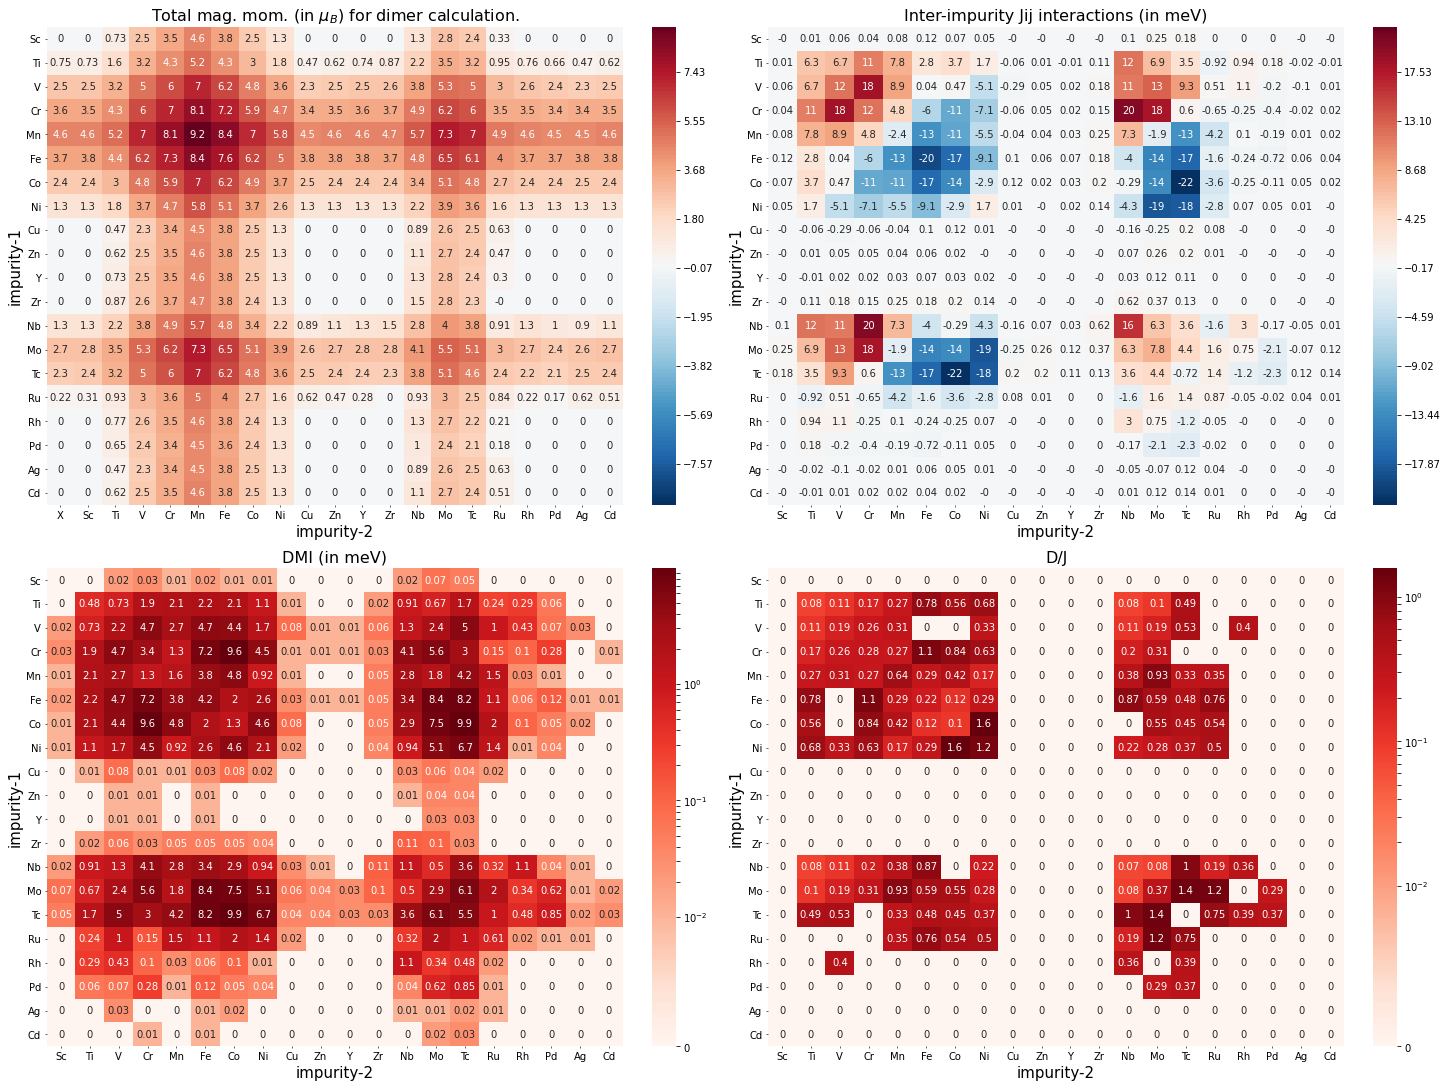

In [6]:
#For total magnetic momentum
dict_for_last_calc_data= {'key1' : 'magnetism_group',
                          'key2' : 'total_spin_moment',
                         }

#For individual impurity calculation
#dict_for_last_calc_data_diff= {'key1':'magnetism_group',
#                          'key2':'spin_moment_per_atom',
#                          'key3': 0,
#                          'key4': 2
#                         }

group_pks= [102]#, 104, 115, 118 ]

for group_pk in group_pks:
    print(load_group(group_pk).label)
    # Extract the ploting data
    # ploting_data_with_diff = extract_ploting_array_data(group_pk, dict_for_last_calc_data=dict_for_last_calc_data_diff, Average= False, plot_with_difference=True)
    ploting_data_without_diff = extract_ploting_array_data(group_pk, Average=False, plot_with_difference=False,
                                                          dict_for_last_calc_data=dict_for_last_calc_data,
                                                          filter_DMI = False)

    #file_name= 'magnetic_moment_diff__' + load_group(group_pk).label + '.pdf'
    file_name= 'total_magnetic_moment__' + load_group(group_pk).label + '.pdf'
    jij, smm =dimer_plot(group_pk, ploting_data=ploting_data_without_diff, with_seaborn=True,  file_name=file_name, save_intofile= False)#, DM_data_array=False,DRatioJ_data_array=False,Jij_data=False) # 


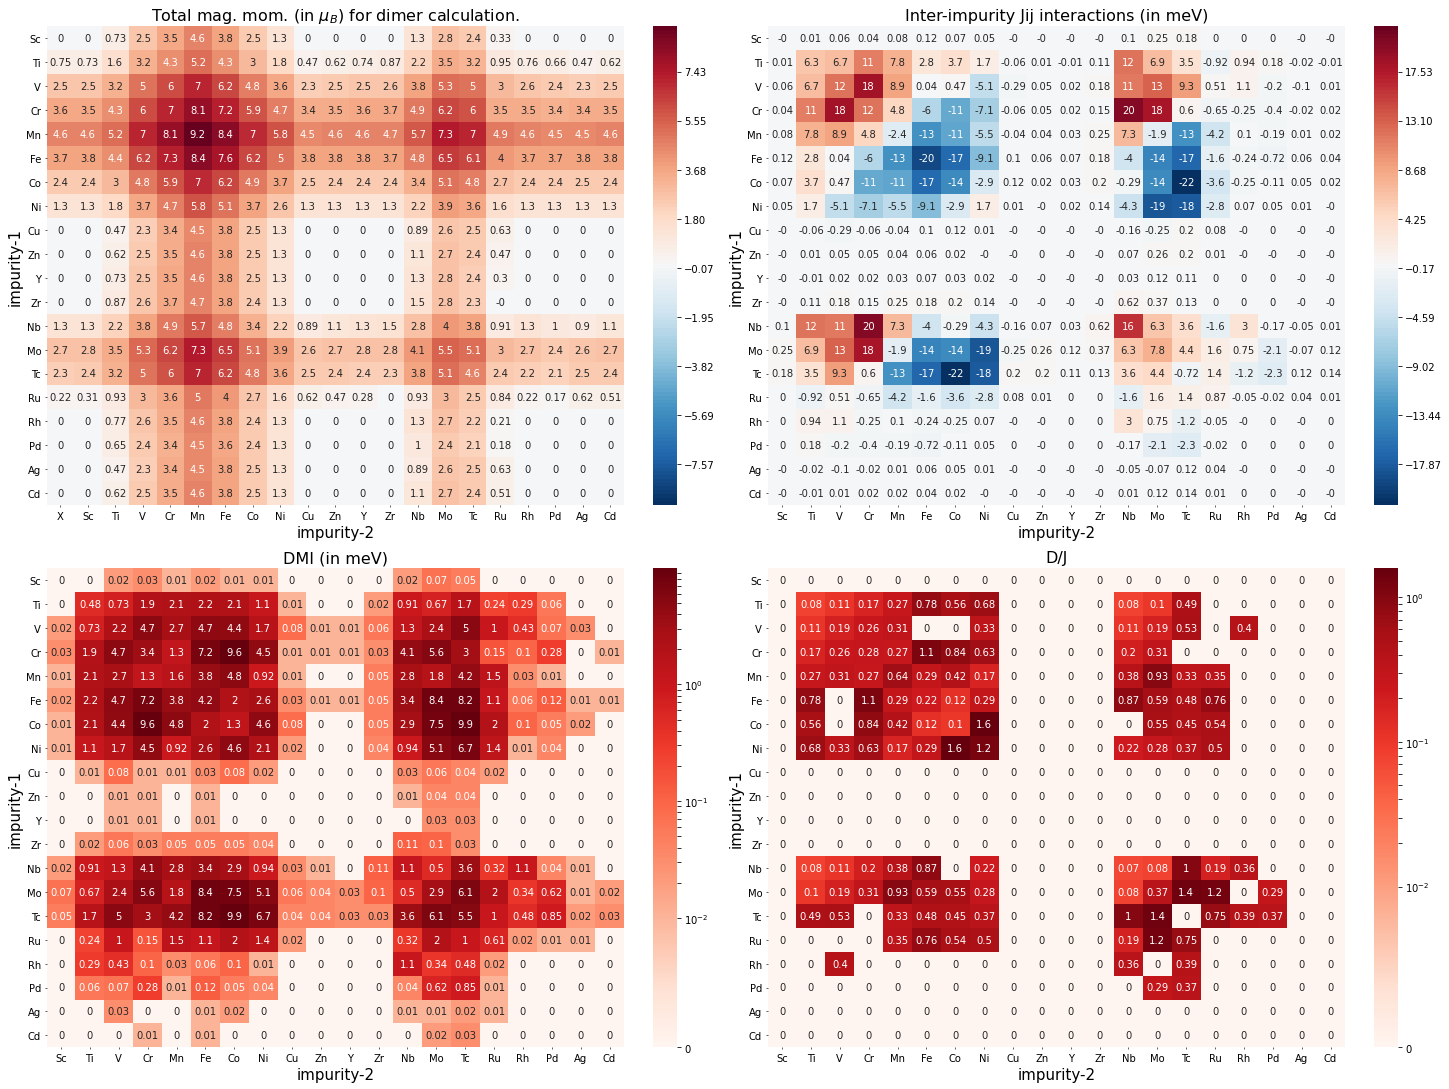

In [7]:
#file_name= 'magnetic_moment_diff__' + load_group(group_pk).label + '.pdf'
#total_magnetic_moment__3d_4d_dope_Bi2Te3_il_3:il_3_offset_1
file_name= 'Jij__' + load_group(group_pk).label + '.png'
jij, smm =dimer_plot(group_pk, ploting_data=ploting_data_without_diff, with_seaborn=True,  file_name=file_name, save_intofile= True)#, DM_data_array=False,DRatioJ_data_array=False,Jij_data=False) # 

In [ ]:
dict_for_last_calc_data= {'key1': 'magnetism_group',
                          'key2': 'total_spin_moment'
#                          'key2': 'spin_moment_per_atom',
#                          'key3': 0,
#                          'key4': 2
                         }
group_pk= 104
# Extract the ploting data
#ploting_data= extract_ploting_array_data(group_pk, dict_for_last_calc_data=dict_for_last_calc_data, Average= False, plot_with_difference=False)

#file_name= 'magnetic_moment_diff__' + load_group(group_pk).label+'.pdf'
file_name= 'imp1_magnetic_moment__'+ load_group(group_pk).label+'.pdf'
jij, smm =dimer_plot(group_pk, ploting_data=ploting_data, with_seaborn=True, file_name=file_name, save_intofile= False)#, DM_data_array=False,DRatioJ_data_array=False,Jij_data=False) # 


In [ ]:
group_pk= 115
#file_name= 'magnetic_moment_diff__' + load_group(group_pk).label+'.pdf'
file_name= 'imp1_magnetic_moment__'+ load_group(group_pk).label+'.pdf'
#diamar_plot(group_pk, with_seaborn=True, dict_for_last_calc_data=dict_for_last_calc_data, Average= False, plot_with_difference= False, file_name=file_name, save_intofile= True)#, DM_data_array=False,DRatioJ_data_array=False,Jij_data=False) # 


In [ ]:
group_pk= 118
#file_name= 'magnetic_moment_diff__' + load_group(group_pk).label+'.pdf'
file_name= 'imp1_magnetic_moment__'+ load_group(group_pk).label+'.pdf'

#diamar_plot(group_pk, with_seaborn=True, dict_for_last_calc_data=dict_for_last_calc_data, Average= False, plot_with_difference=False, file_name=file_name, save_intofile= True)#, DM_data_array=False,DRatioJ_data_array=False,Jij_data=False) # 


In [6]:
## Some other plots for combined_imps data
## Spin momentum along the z axis taking count only one imp of the two
## TODO: Also add the another data for second same impurity and average them, The calcualation AB and BA
import matplotlib as mpl
group = file_name

mpl.style.use('ggplot')
spin_data_array, spin_xtick_labels, spin_ytick_labels = ExtractLastCalcData(group, Average= False, key1 = 'magnetism_group', key2='spin_moment_per_atom' , key3=0, key4=2)
## here the parameter 'average' should set to be false as here nothing to be average as this anly use for np.array 

# spin_data_array
arr_shape= np.shape(spin_data_array)
max_val= np.max(spin_data_array)
min_val= np.min(spin_data_array)
xtick_loc= range(len(spin_xtick_labels[1:]))
xtick_lab = spin_xtick_labels[1:]


n = arr_shape[0]
color = plt.cm.hot_r(np.linspace(0.1,0.9,n)) # This returns RGBA; convert:
line_design= ['o--', 'o-', '+--', '--', '*--']
    
fig, ax_zs_mom= plt.subplots(1,1, figsize=(15,10))
for i in range(arr_shape[0]):
    
    line= list(spin_data_array[i,1:])
    ax_zs_mom.plot(line, line_design[i%len(line_design)], label=f'{spin_ytick_labels[i]}', color= color[n-1-i])
leg= ax_zs_mom.legend(loc= 'upper right', shadow= True, bbox_to_anchor=[1.3,1],  ncol= 2, title="impurities", fancybox= True )
leg.get_title().set_color('blue')
leg.get_title().set_fontsize(15)
plt.xticks(xtick_loc, xtick_lab)
plt.show()


NameError: name 'file_name' is not defined

In [6]:
# The uptput dict format for extract_ploting_array_data function

#ploting_data_with_diff = {'spin_data_array': (array(),
#  ['X', 'V', 'Cr', 'Mn', 'Mo', 'Tc'],
#  ['V', 'Cr', 'Mn', 'Mo', 'Tc']),
# 'Jij_data_array': (array(),
#  ['V', 'Cr', 'Mn', 'Mo', 'Tc'],
#  ['V', 'Cr', 'Mn', 'Mo', 'Tc'],
#  {'some_info': {'imp_indices': (0, 15),
#    'atom_distance': 1.2555446807174,
#    'alat': 8.2826,
#    'alat_unit': 'Bohr'}}),
# 'DM_data_array': (array(),
#  ['V', 'Cr', 'Mn', 'Mo', 'Tc'],
#  ['V', 'Cr', 'Mn', 'Mo', 'Tc'],
#  {'some_info': {'imp_indices': (0, 15),
#    'atom_distance': 1.2555446807174,
#    'alat': 8.2826,
#    'alat_unit': 'Bohr'}}),
# 'DRatioJ_data_array': (array(),
#                        
#  ['V', 'Cr', 'Mn', 'Mo', 'Tc'],
#  ['V', 'Cr', 'Mn', 'Mo', 'Tc'],
#  {'some_info': {'imp_indices': (0, 15),
#    'atom_distance': 1.2555446807174,
#    'alat': 8.2826,
#    'alat_unit': 'Bohr'}})}

In [6]:
###### Ploting distance Vs Magnetic moment

#def collect_Jij_data(group_list=[104,102, 118, 115], Average= None):
    
def collect_Jij_data(group_list=[104,102, 118, 115], data_label = ['Jij', 'Dij', 'J/D'], Average= False ):
    
    #To colloect the Jij Data
    accending_distance_group = group_list
    dict_for_last_calc_data= {'key1':'magnetism_group',
                              'key2':'spin_moment_per_atom',
                              'key3': 0,
                              'key4': 2
                             }

    group_to_plot_data_and_some_info_dict = dict()
    dis_com_map = dict()
    # Extract the stract the jij_data and atomic distance
    for group_pk in accending_distance_group:
        ploting_data_with_diff = extract_ploting_array_data(group_pk,
                                 dict_for_last_calc_data=None,
                                 spin_data= False,
                                 Jij_data= True,
                                 DM_data_array= True,
                                 DRatioJ_data_array= True,
                                 Average= False,
                                 plot_with_difference= False,
                                 filter_DMI = False,# Filter the array with respect to Jij array
                                 filter_DMI_by_Jij= True, # Filter the array with respect to Jij array
                                 filter_by_max_Jij_value= 1, # If Jij >= 1 than Dji set to zero
                                )


        group_to_plot_data_and_some_info_dict[str(group_pk)] = dict()
        
        if 'Jij' in data_label and 'Jij_data_array' in ploting_data_with_diff.keys():
            Jij_data_array, Jij_xtick_labels, Jij_ytick_labels, some_info_dict  = ploting_data_with_diff['Jij_data_array']

            group_to_plot_data_and_some_info_dict[str(group_pk)]['Jij'] = (Jij_data_array, Jij_xtick_labels, 
                                                                           Jij_ytick_labels, some_info_dict)
        if 'Dij' in data_label and 'DM_data_array' in ploting_data_with_diff.keys():
            Dij_data_array, Dij_xtick_labels, Dij_ytick_labels, some_info_dict  = ploting_data_with_diff['DM_data_array']
            group_to_plot_data_and_some_info_dict[str(group_pk)]['Dij'] = (Dij_data_array, Dij_xtick_labels, 
                                                                           Dij_ytick_labels, some_info_dict)
        if 'J/D' in data_label and 'DRatioJ_data_array' in ploting_data_with_diff.keys():
            DRatioJ_data_array, DRatioJ_xtick_labels, DRatioJ_ytick_labels, some_info_dict  = ploting_data_with_diff['DRatioJ_data_array']
            group_to_plot_data_and_some_info_dict[str(group_pk)]['D/J'] = (DRatioJ_data_array, DRatioJ_xtick_labels, 
                                                                           DRatioJ_ytick_labels, some_info_dict)
        
        
    return group_to_plot_data_and_some_info_dict


# Parse data from the Jij_data_and_some_info_dict to the Json Type file
def parse_to_Json(plot_imp_list, group_to_plot_data_and_some_info_dict,
                  imp1_plot_list= None, average= True):
    
    """Describtion.
    Arguments:
        plot_imp_list: all cmbination of the imps will be ploted
        
        group_to_Jij_daa_and_some_info_dict: gives the dict in format
                                            {group: (Jij_data_array, Jij_xtick_labels, 
                                                    Jij_ytick_labels, some_info_dict) }
        
    """
    
    group_list = list(group_to_plot_data_and_some_info_dict.keys())
    dat_typ_lis = list(group_to_plot_data_and_some_info_dict[group_list[0]].keys())

    plot_data = []
    
    for imp1 in plot_imp_list:

        single_plot_data = {'imp1': imp1,
                     'imp2' : None}
        imp2_dict = dict() 

        for imp2 in plot_imp_list:
            if 'Jij' in dat_typ_lis:
                Jij = []
            if 'Dij' in dat_typ_lis:
                Dij = []
            if 'D/J' in dat_typ_lis:
                DRatioJ = []
            dist = []
            
            for grp in group_list:
                if 'Jij' in dat_typ_lis:
                    Jij_array, x_labels, y_labels, info_dict = group_to_plot_data_and_some_info_dict[grp]['Jij']
                if 'Dij' in dat_typ_lis:
                    Dij_array, x_labels, y_labels, info_dict = group_to_plot_data_and_some_info_dict[grp]['Dij']
                if 'D/J' in dat_typ_lis:
                    DRatioJ_array, x_labels, y_labels, info_dict = group_to_plot_data_and_some_info_dict[grp]['D/J']
                    
                ind1, ind2 = x_labels.index(imp1), y_labels.index(imp2)
                if 'Jij' in dat_typ_lis:
                    Jij.append(Jij_array[ind1, ind2])
                
                if 'Dij' in dat_typ_lis:
                    Dij.append(Dij_array[ind1, ind2])
                
                if 'D/J' in dat_typ_lis:
                    DRatioJ.append(DRatioJ_array[ind1, ind2])
                
                dist.append(info_dict['some_info']['atom_distance'])
                
            imp2_dict[imp2] = {'Jij' : Jij,
                               'Dij' : Dij,
                               'D/J' : DRatioJ,
                               'dist' : dist}
        
        single_plot_data['imp2'] = imp2_dict
        plot_data.append(single_plot_data)
        
    return plot_data

In [8]:
# Delete

#xx = collect_Jij_data(group_list=[148, 149, 150])

In [8]:
#### To collect data from all dimar group

grps = [102, 104, 115, 118, 145, 146, 147, 148, 149, 150]
#grps = [145, 146, 147, 148, 149, 150]
# Note 140 is not completed
group_to_Jij_data_and_some_info_dict = collect_Jij_data(group_list= grps,)
ll = list(group_to_Jij_data_and_some_info_dict.keys())
type(group_to_Jij_data_and_some_info_dict[ll[0]])

len of plot_imp_row_list 20
len of plot_imp_col_list 20
len of plot_imp_row_list 20
len of plot_imp_col_list 21
['X', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd']
['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd']
len of plot_imp_row_list 20
len of plot_imp_col_list 20
len of plot_imp_row_list 20
len of plot_imp_col_list 20
len of plot_imp_row_list 20
len of plot_imp_col_list 20
len of plot_imp_row_list 20
len of plot_imp_col_list 21
['X', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd']
['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd']
len of plot_imp_row_list 20
len of plot_imp_col_list 20
len of plot_imp_row_list 20
len of plot_imp_col_list 20
len of plot_imp_row_list 20
len of plot_imp_col_list 20
len of plo

dict

In [9]:
#group_to_Jij_data_and_some_info_dict

In [10]:
#for grp in grps[-4:]:
#    grp_140 = load_group(grp)
#    grp_nodes = list(grp_140.nodes)
#    for nod in grp_nodes:
#        print('node label: ', nod.label)
#    print('total nodes :', len(grp_nodes), 'and group label:\n', grp_140.label)
#    print('\n', grp_140.pk)

In [7]:
#### To extract data in json formate for ploting jij_vs_dist
lattice_const = 10.4726
plot_data = parse_to_Json(['V', 'Cr', 'Mn', 'Mo', 'Tc', 'Nb'], group_to_Jij_data_and_some_info_dict)

dis_comb_label_map=dict()

for grp_pk in group_to_Jij_data_and_some_info_dict.keys():
    dis_comb_label_map[group_to_Jij_data_and_some_info_dict[grp_pk]['Jij'][3]['some_info']['atom_distance']] = load_group(int(grp_pk)).label

print(dis_comb_label_map)

NameError: name 'parse_to_Json' is not defined

In [8]:
0.83702978714494*10.4726

8.7658781488541

In [7]:
import json

### To save the data in json file
#with open('dis_comb_label_map.Json', 'w') as f:
#    json.dump(dis_comb_label_map,f)
#    
#with open('impurity_jij_dis_plot_data.Json', 'w') as f:
#    json.dump(plot_data, f)
  

### To load the data from json file

with open('dis_comb_label_map.Json', 'r') as f:
    dis_comb_label_map = json.load(f)
with open('impurity_jij_dis_plot_data.Json', 'r') as f:
    plot_data = json.load(f)
#len(plot_data[0]['imp2']['V']['jij'])


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as m

font = {'family':'normal',
        'weight': 'bold',
        'size':12}
m.rc('font',**font)
colors = ['b', 'g', 'r', 'c', 'm', 'y']

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


<Figure size 1800x1296 with 0 Axes>

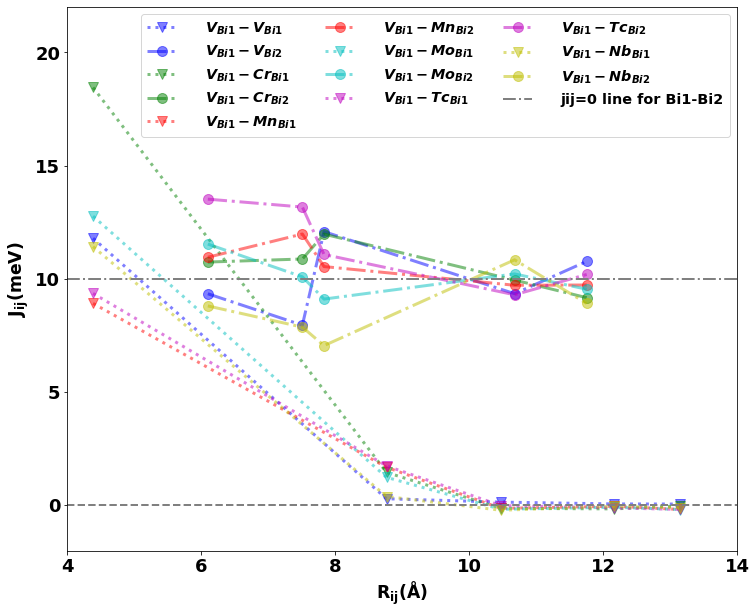

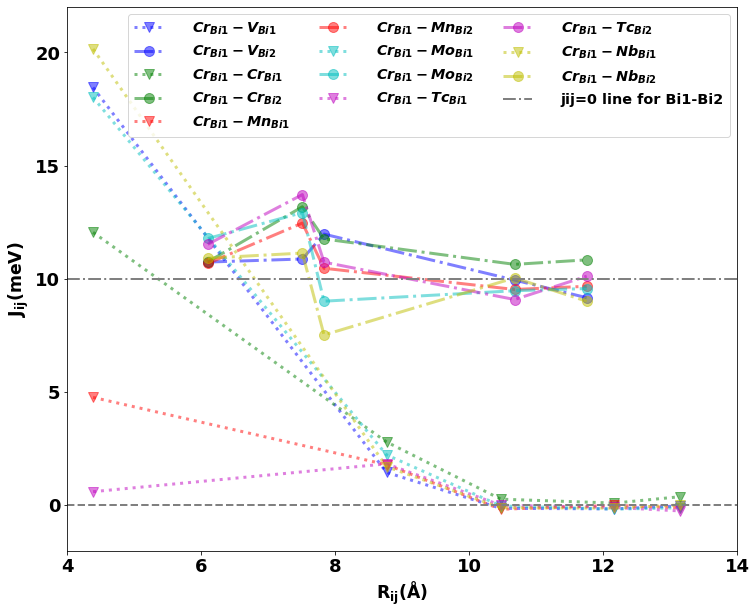

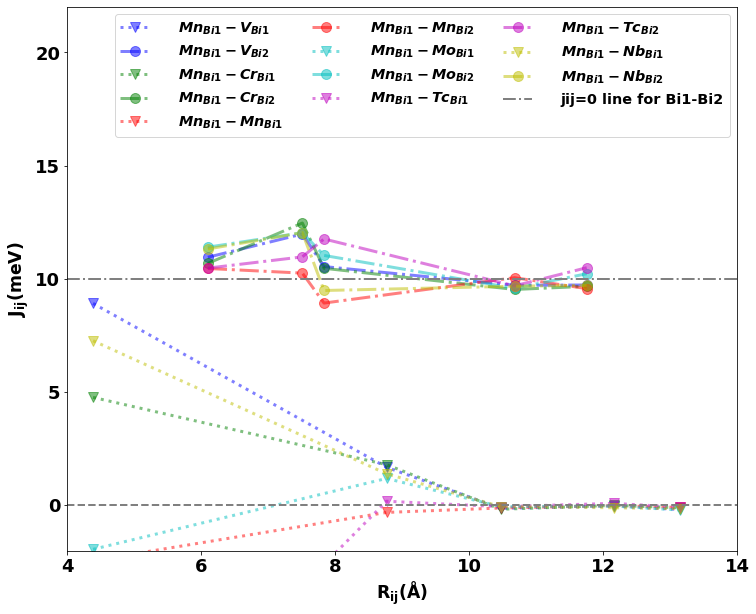

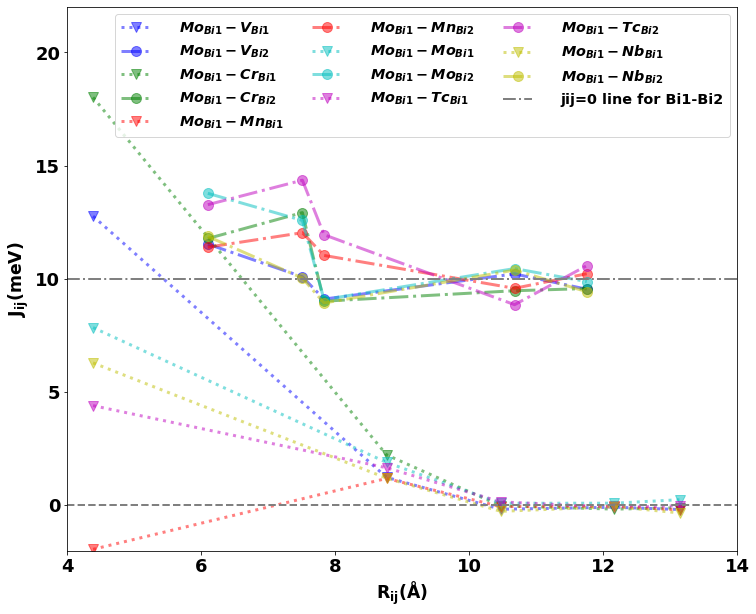

In [14]:
# print(dis_comb_label_map)
# This part is for seperation 
# Bi1 Vs Bi1 and Bi1 Vs Bi2

Bi1_Bi1 = 'il_3:il_3'
Bi1_Bi2 = 'il_3:il_4'

dis_Bi1_Bi1 = []
dis_Bi1_Bi2 = []

for dist_val in dis_comb_label_map.keys():
    
    grp_label = dis_comb_label_map[dist_val]
    
    if Bi1_Bi1 in grp_label:
        dis_Bi1_Bi1.append(float(dist_val))
    if Bi1_Bi2 in grp_label:
        dis_Bi1_Bi2.append(float(dist_val))
dis_Bi1_Bi1.sort()
dis_Bi1_Bi2.sort()

number_of_plot = 4
plt.figure(figsize=(25,18))
row, col = (2, 2)
#print(row, col)

tot_plot_num = len(plot_data)
number_of_plot = tot_plot_num
figure_index = 0

# distanceunit to Angstom
dis_unit = 10.472657559692419 #ang

for fig_cor_row in range(row):
    for fig_cor_col in range(col):
        figure_index += 1
        if (figure_index > number_of_plot) or (figure_index > tot_plot_num):
            continue
        imp1_data = plot_data[figure_index-1]
        
        sImp1 = imp1_data['imp1']
        sImp2_list = list(imp1_data['imp2'].keys())
        
        if (figure_index > number_of_plot) or (figure_index > tot_plot_num):
                continue
                
        #plt.subplot(row, col, figure_index)
        plt.figure(figsize=(12,10))
        
        Bi1_Bi1_data_shift = 0
        Bi1_Bi2_data_shift = 10
        i = 0
        for sImp2 in sImp2_list:
            x = imp1_data['imp2'][sImp2]['dist']
## Change the following line as
#    for Jij key = Jij
#    Dij key = Dij
#    D ratio J key = D/J
            key = 'Jij'
            y = imp1_data['imp2'][sImp2][key] 
            
            jij_1_1 = np.array([y[x.index(val)] for val in dis_Bi1_Bi1])
            jij_1_2 = np.array([y[x.index(val)] for val in dis_Bi1_Bi2])            
            
            orderd_x = x.copy()
            orderd_x.sort()
            y = [y[x.index(value)] for value in orderd_x ]
            x = np.array(orderd_x)*dis_unit

            Bi1_Bi1 = np.array(dis_Bi1_Bi1)*dis_unit
            Bi1_Bi2 = np.array(dis_Bi1_Bi2)*dis_unit
            
            label= sImp1 + ':' + sImp2
#            plt.plot(x, y, 's', label= label, ls='--', color= colors[i], linewidth=3)
            # the fllowing code for 3_3 and 3_4 separately
            
            plt.plot(Bi1_Bi1, (jij_1_1)+Bi1_Bi1_data_shift, 'v',ms=10, label= '${}_{{Bi1}}-{}_{{Bi1}}$'.format(sImp1, sImp2),
                    alpha = 0.5, ls=':', color=colors[i], linewidth=3)
            plt.plot(Bi1_Bi2, jij_1_2+Bi1_Bi2_data_shift, 'o', ms=10,label= '${}_{{Bi1}}-{}_{{Bi2}}$'.format(sImp1, sImp2),
                     alpha = 0.5, ls='-.', color=colors[i], linewidth=3)
           
            #plt.title('{} Vs (V, Cr, Mn, Mo)'.format(sImp1))
            plt.xlabel('$\mathrm{R_{ij} (\AA)}$', fontsize='x-large')
            plt.ylabel('$\mathrm{J_{ij} (meV)}$', fontsize='x-large')
            #plt.ylabel('$\mathrm{D_{ij}\;/\;j_{ij}}$', fontsize='x-large')

            i  = i+1
        
        plt.xticks(size = 18)
        plt.yticks(size = 18)
        plt.ylim(-2, 5) # for D/J
        plt.ylim(-2, 22)
        plt.xlim(4,14)
#        plt.axhline(Bi1_Bi1_data_shift, ls= ':', color='grey', label='jij=0 line for Bi1-Bi1', linewidth=2)
        plt.axhline(Bi1_Bi2_data_shift, ls= '-.', color='grey', label='jij=0 line for Bi1-Bi2', linewidth=2)
        plt.axhline(0, ls='--', color='grey', linewidth=2)
        plt.legend(fontsize='large', loc=1,handletextpad=2, ncol=3)
        title= sImp1+'_Jij_3_3_and_3_4.png'
        plt.tight_layout
        plt.savefig(title, bbox_inches= 'tight', dpi=300)
        #plt.savefig(title+'.pdf', bbox_inches= 'tight')
        

In [34]:
jij_1_1

array([0.08, 1.14, 0.  , 0.  , 0.  ])

In [12]:
grps = [145, 146, 147, 148, 149, 150]


In [38]:
#To check the plot data
nodes_149 = list(load_group(149).nodes)
nodes_150 = list(load_group(150).nodes)

#load Jij dada
ex_node = nodes_150[1]

xx = ex_node#.inputs. scf.get_dict()
lab_to_Jij = {}

for node_ in (nodes_149+nodes_150):
     lab_to_Jij[node_.label] = (np.sum(np.square(node_.outputs.JijData.get_array('JijData')[0][0:3])),node_.outputs.JijData.get_array('JijData')[0][3])
        
for node_1 in nodes_149:
    for node_2 in nodes_150:
        if 'Cr' in node_1.label:
            search_label = node_1.label.split('Off')[0]
            if search_label in node_2.label:
                print(f'Jij in node {node_1.label} = {lab_to_Jij[node_1.label]} and \n Jij in node {node_2.label} = {lab_to_Jij[node_2.label]} \n\n') 
                

Jij in node V:Cr:Bi2Te3_il_3_3_Off_4 = (1.3503094322839488, 1.6788702328086986) and 
 Jij in node V:Cr:Bi2Te3_il_3_3_Off_5 = (1.5763924452777578, 1.6788702328086986) 


Jij in node Cr:Cr:Bi2Te3_il_3_3_Off_4 = (1.3503094322839488, 1.474018152986374) and 
 Jij in node Cr:Cr:Bi2Te3_il_3_3_Off_5 = (1.5763924452777578, 1.474018152986374) 


Jij in node Cr:Mn:Bi2Te3_il_3_3_Off_4 = (1.3503094322839488, 0.7234749296301587) and 
 Jij in node Cr:Mn:Bi2Te3_il_3_3_Off_5 = (1.5763924452777578, 0.7234749296301587) 


Jij in node Cr:Mo:Bi2Te3_il_3_3_Off_4 = (1.3503094322839488, 1.1862213281159801) and 
 Jij in node Cr:Mo:Bi2Te3_il_3_3_Off_5 = (1.5763924452777578, 1.1862213281159801) 


Jij in node Cr:Tc:Bi2Te3_il_3_3_Off_4 = (1.3503094322839488, -0.09654198752835742) and 
 Jij in node Cr:Tc:Bi2Te3_il_3_3_Off_5 = (1.5763924452777578, -0.09654198752835742) 




In [ ]:
node_1.inputs.offset_imp2.get_dict(), node_2.inputs.offset_imp2.get_dict()

({'index': 4}, {'index': 5})

In [ ]:
node_1.called[2].inputs.impurity_info.get_dict()

In [ ]:
np.sum(np.array(node_1.called[2].inputs.impurity_info.get_dict()['Rimp_rel'])**2, axis=1)

array([0.        , 1.35030943])

In [ ]:
np.sum(np.array(node_2.called[2].inputs.impurity_info.get_dict()['Rimp_rel'])**2, axis=1)

array([0.        , 1.57639245])

In [ ]:
node_1.called[-2].attributes

{'sealed': True,
 'version': {'core': '1.6.5', 'plugin': '1.1.11-dev4'},
 'exit_status': 0,
 'function_name': 'parse_Jij',
 'process_label': 'parse_Jij',
 'process_state': 'finished',
 'function_namespace': 'aiida_kkr.workflows._combine_imps',
 'function_starting_line_number': 851}

In [ ]:
builder = node_1.get_builder_restart()

In [ ]:
builder.gf_host_remote?

Type:        property
String form: <property object at 0x7f467cafa4a0>
Docstring:   {"name": "gf_host_remote", "required": "False", "valid_type": "<class 'aiida.orm.nodes.data.remote.base.RemoteData'>", "help": "RemoteData node of pre-calculated host Green function (i.e. with kkr_flex_wc).\nIf given then the writeout step of the host GF is omitted.", "non_db": "False"}


In [ ]:
b = combine_imps_wc.get_builder()

In [ ]:
b


Type:           ProcessBuilder
String form:    {'metadata': {}, 'scf': {}, 'host_gf': {}}
Length:         3
File:           /opt/aiida-core/aiida/engine/processes/builder.py
Docstring:      A process builder that helps setting up the inputs for creating a new process.
Init docstring:
Construct a `ProcessBuilder` instance for the given `Process` class.

:param process_class: the `Process` subclass


In [ ]:
node_1.inputs.gf_host_remote, node_2.inputs.gf_host_remote

(<RemoteData: uuid: 1f349887-0cfa-46a2-9e9b-a33cf93d5174 (pk: 110847)>,
 <RemoteData: uuid: 1f349887-0cfa-46a2-9e9b-a33cf93d5174 (pk: 110847)>)

In [ ]:
ret1 = node_1.called[-2].inputs.retrieved
with ret.open('tmp', 'w') as _f:
    print(_f.name)
    
ret2 = node_2.called[-2].inputs.retrieved
with ret.open('tmp', 'w') as _f:
    print(_f.name)

/home/mozumder/.aiida/repository/default/repository/node/b4/27/3e69-665b-4676-ba9e-775d4e625631/path/tmp
/home/mozumder/.aiida/repository/default/repository/node/b4/27/3e69-665b-4676-ba9e-775d4e625631/path/tmp


In [ ]:
c1 = ret1.get_incoming().first().node
c2 = ret2.get_incoming().first().node

(<CalcJobNode: uuid: 466c0a4d-afbb-4e48-b539-3ca53806d9ff (pk: 114745) (aiida.calculations:kkr.kkrimp)>,
 <CalcJobNode: uuid: 90a4c68c-fb09-481a-9098-f07987b90a36 (pk: 114828) (aiida.calculations:kkr.kkrimp)>)

In [102]:
i1 = np.array(c1.inputs.impurity_info.get_dict()['imp_cls'])

In [103]:
i2 = np.array(c2.inputs.impurity_info.get_dict()['imp_cls'])

In [112]:
c1.inputs.host_Greenfunction_folder

<RemoteData: uuid: 1f349887-0cfa-46a2-9e9b-a33cf93d5174 (pk: 110847)>

In [114]:
c2.inputs.host_Greenfunction_folder.get_incoming()

In [108]:
!verdi process report 114745

*** 114745 [KKRimp_Jij (Zimp: [43, 43])]: None
*** (empty scheduler output file)
*** Scheduler errors:
srun: TOPOLOGY: warning -- no switch can reach all nodes through its descendants.Do not use route/topology

*** 9 LOG MESSAGES:
+-> REPORT at 2021-10-08 00:49:55.203242+00:00
 | [114745|KkrimpCalculation|_extract_and_write_config]: Found CALCJIJMAT=1: trigger JIJ mode which overwrites IMIX, MIXFAC, SCFSTEPS and RUNFLAGs
+-> REPORT at 2021-10-08 00:49:55.209010+00:00
 | [114745|KkrimpCalculation|_get_pot_and_shape]: Write scoef from imp_cls input! 30
+-> REPORT at 2021-10-08 00:49:55.304024+00:00
 | [114745|KkrimpCalculation|_change_atominfo]: DEBUG: Rimp_rel_list: [[0.0, 0.0, 0.0], [-0.6277723403587, -0.12081484323197, -0.97036853546441]].
+-> REPORT at 2021-10-08 00:49:55.306786+00:00
 | [114745|KkrimpCalculation|_change_atominfo]: INFO: Rimp_rel 0, [0. 0. 0.]
+-> REPORT at 2021-10-08 00:49:55.309140+00:00
 | [114745|KkrimpCalculation|_change_atominfo]: INFO: Rimp_rel 1, [-0.62777234

In [106]:
(i1-i2)

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.

In [87]:
node_2.called[-2].inputs.retrieved.get_incoming().first().node

<CalcJobNode: uuid: 90a4c68c-fb09-481a-9098-f07987b90a36 (pk: 114828) (aiida.calculations:kkr.kkrimp)>

In [76]:
node_1.called[-2].outputs['Jijdata'].get_array('JijData')

array([[-0.62777234, -0.12081484, -0.97036854, -1.36252501,  0.93242426,
        -0.51093784, -0.32857984,  0.70738449]])

In [77]:
node_2.called[-2].outputs['Jijdata'].get_array('JijData')

array([[-1.25554468,  0.        ,  0.        , -1.36252501,  0.93242426,
        -0.51093784, -0.32857984,  0.70738449]])

In [70]:
a1 = node_1.called[-1].outputs.result.get_dict()
a2 = node_2.called[-1].outputs.result.get_dict()

list(a1)

['magmoms',
 'successful',
 'sub_workflows',
 'workflow_name',
 'run_option_info',
 'workflow_version',
 'convergence_value',
 'imp_info_combined',
 'convergence_reached',
 'potential_kickout_info',
 'imps_info_in_exact_cluster',
 'convergence_values_all_steps']

In [66]:
np.array(a1['magmoms']) - np.array(a2['magmoms'])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
np.array(a1['magmoms']) - np.array(a2['magmoms'])

In [33]:
from aiida.common import NotExistentAttributeError, NotExistent

nodes = []

for grp_pk in grps:
    nodes = nodes + (list(load_group(grp_pk).nodes))
    
for node_ in nodes:
    try:
        gf_node = node_.inputs.gf_host_remote.get_incoming(node_class=combine_imps_wc).all()[0].node
        label = gf_node.pk
        print('gf_node : ', label, 'combine_node : ', node_.pk) 
    except NotExistentAttributeError:
        print('jjjj')
    except NotExistent:
        print('jjjj')
    except KeyError:
        print('jjjj')

gf_node :  110833 combine_node :  112462
gf_node :  110833 combine_node :  112463
gf_node :  110833 combine_node :  112464
gf_node :  110833 combine_node :  112465
gf_node :  110833 combine_node :  112466
gf_node :  110833 combine_node :  112467
gf_node :  110833 combine_node :  112468
gf_node :  110833 combine_node :  112469
gf_node :  110833 combine_node :  112470
gf_node :  110833 combine_node :  112471
gf_node :  110833 combine_node :  112472
gf_node :  110833 combine_node :  112473
gf_node :  110833 combine_node :  112474
gf_node :  110833 combine_node :  115338
gf_node :  110833 combine_node :  115344
jjjj
gf_node :  110833 combine_node :  110890
gf_node :  110833 combine_node :  110894
gf_node :  110833 combine_node :  110902
gf_node :  110833 combine_node :  110906
gf_node :  110833 combine_node :  110920
gf_node :  110833 combine_node :  110927
gf_node :  110833 combine_node :  110931
gf_node :  110833 combine_node :  110938
gf_node :  110833 combine_node :  110944
gf_node :  

In [125]:
node_1 = load_node(114745)

In [133]:
ret= node_1.outputs.retrieved
with ret.open('tmp', 'r') as f:
    test = f.readlines()
#ret.list_object_names()
test

[]

In [ ]:
pd_data